In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


In [39]:
import kagglehub
import pathlib

path = kagglehub.dataset_download("hgultekin/bbcnewsarchive")
df = pd.read_csv(pathlib.Path(path) / "bbc-news-data.csv", sep="\t")
df


,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...,...
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...


In [40]:
from sklearn.model_selection import train_test_split


df, _ = train_test_split(df, train_size=0.2, stratify=df["category"], random_state=0)
df


,category,filename,title,content
1933,tech,110.txt,Podcasts mark rise of DIY radio,An Apple iPod or other digital music players ...
919,politics,024.txt,Brown visits slum on Africa trip,Chancellor Gordon Brown has visited Kenya's b...
1052,politics,157.txt,Kilroy-Silk attacked with slurry,Euro MP Robert Kilroy-Silk has had a bucket o...
754,entertainment,245.txt,Mogul Wilson backing UK rap band,"Tony Wilson, the music mogul who established ..."
264,business,265.txt,Troubled Marsh under SEC scrutiny,The US stock market regulator is investigatin...
...,...,...,...,...
437,business,438.txt,UK interest rates held at 4.75%,The Bank of England has left interest rates o...
1655,sport,343.txt,England coach faces rap after row,England coach Andy Robinson is facing discipl...
1080,politics,185.txt,Police probe BNP mosque leaflet,Police are investigating a British National P...
1550,sport,238.txt,Ferguson puts faith in youngsters,Manchester United manager Sir Alex Ferguson s...


In [41]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import os

NLTK_DATA_PATH = os.path.join(os.getcwd(), "nltk_data")
os.makedirs(NLTK_DATA_PATH, exist_ok=True)

nltk.data.path.append(NLTK_DATA_PATH)

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")


[nltk_data] Downloading package punkt to /home/trisolaris/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/trisolaris/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/trisolaris/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/trisolaris/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [42]:
def preprocess_text(text):
    text = text.lower()

    text = text.translate(str.maketrans("", "", string.punctuation))

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    tokens = [word for word in tokens if len(word) > 2]

    return tokens


def create_document_term_matrix(df):
    all_words = []
    for tokens in df["processed_content"]:
        all_words.extend(tokens)

    word_counts = Counter(all_words)

    vocabulary = dict([key, idx] for idx, key in enumerate(word_counts.keys()))
    dtm = np.zeros((len(df), len(vocabulary)), dtype=np.uint32)

    for i, tokens in enumerate(df["processed_content"]):
        for word in tokens:
            dtm[i, vocabulary[word]] += 1

    return dtm, vocabulary


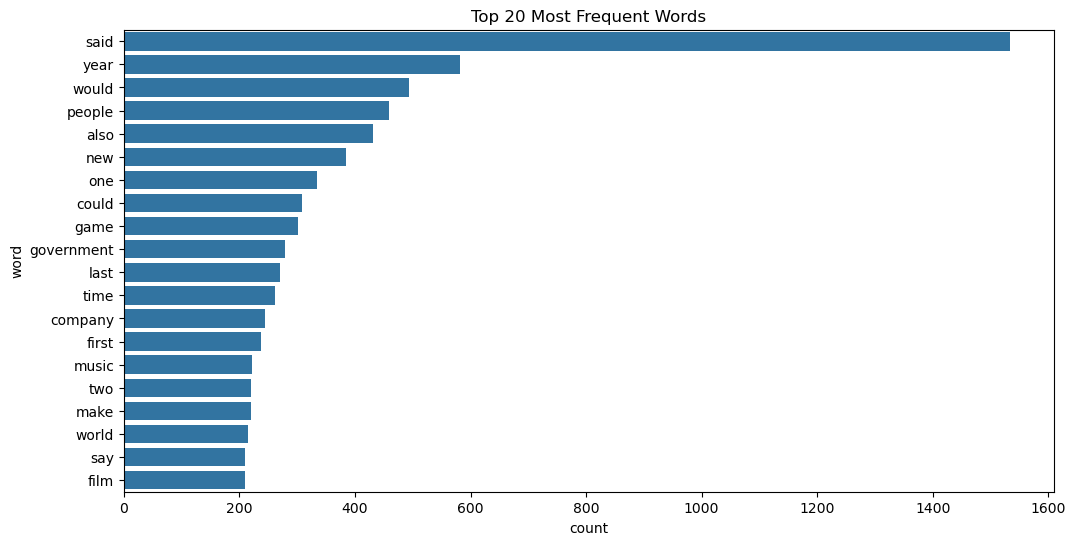

In [43]:
df["processed_content"] = df["content"].apply(preprocess_text)

dtm, vocabulary = create_document_term_matrix(df)
feature_names = list(vocabulary.keys())

word_freq_df = pd.DataFrame(
    {"word": list(vocabulary.keys()), "count": dtm.sum(axis=0)}
).sort_values("count", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x="count", y="word", data=word_freq_df.head(20))
plt.title("Top 20 Most Frequent Words")
plt.show()


In [44]:
df["processed_content"]


1933    [apple, ipod, digital, music, player, hold, an...
919     [chancellor, gordon, brown, visited, kenya, bi...
1052    [euro, robert, kilroysilk, bucket, farm, slurr...
754     [tony, wilson, music, mogul, established, infl...
264     [stock, market, regulator, investigating, trou...
                              ...                        
437     [bank, england, left, interest, rate, hold, 47...
1655    [england, coach, andy, robinson, facing, disci...
1080    [police, investigating, british, national, par...
1550    [manchester, united, manager, sir, alex, fergu...
1715    [six, nation, heralded, new, order, northern, ...
Name: processed_content, Length: 445, dtype: object

In [45]:
from typing import Literal
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel


def get_coherence(
    phi: np.ndarray,
    feature_names: list[str],
    top_n: int = 20,
    cohere_kind: Literal["c_v"] | str = "c_v",
) -> float:
    if cohere_kind == "c_v":
        corpus = []
        for doc in dtm:
            doc_words = []
            for word_idx, count in enumerate(doc):
                if count > 0:
                    doc_words.extend([feature_names[word_idx]] * int(count))
            corpus.append(doc_words)

        dictionary = Dictionary(corpus)

        top_idx = np.argsort(phi, axis=1)[:, -top_n:][:, ::-1]

        topics = [[dictionary[w_id] for w_id in row] for row in top_idx]

        coherence_model = CoherenceModel(
            topics=topics, texts=corpus, dictionary=dictionary, coherence="c_v"
        )

        return coherence_model.get_coherence()
    raise Exception(f"No support {cohere_kind}")


In [46]:
def customLDA(
    doc_term_matrix: np.ndarray,  # [document_index, word_index] = word_count
    topic_count: int = 5,
    alpha: float = 1,
    beta: float = 0.1,
    iteration: int = 50,
):
    doc_term_matrix = doc_term_matrix.astype(np.int32)
    [D, V], T = (
        doc_term_matrix.shape,
        topic_count,
    )  # documents, vocabulary size, topic count

    phi = np.zeros((T, V), dtype=np.int32)  # темы × слова
    theta = np.zeros((D, T), dtype=np.int32)  # документы × темы

    rows, cols = np.where(doc_term_matrix > 0)
    counts = doc_term_matrix[rows, cols]

    token_document_map = np.repeat(rows, counts)  # (N_tokens,)
    token_word_map = np.repeat(cols, counts)
    token_topic_map = np.random.randint(
        0, topic_count, token_document_map.size, dtype=np.int32
    )

    token_idx_ptr = np.zeros(D + 1, dtype=np.int32)
    token_idx_ptr[1:] = np.cumsum(doc_term_matrix.sum(axis=1))
    word_per_topics = np.zeros(
        shape=(V, T), dtype=np.int32
    )  # отдельно каждое слово в каждом топике
    np.add.at(word_per_topics, (token_word_map, token_topic_map), 1)
    words_count_by_topic = np.bincount(
        token_topic_map, minlength=T
    )  # сколько слов в топике
    word_topic_by_document = np.zeros(
        shape=(D, T), dtype=np.int32
    )  # сколько всего слов в документе помечено темой
    np.add.at(word_topic_by_document, (token_document_map, token_topic_map), 1)
    for _iter in range(1, iteration):
        for token_idx in np.random.permutation(token_document_map.shape[0]):
            document = token_document_map[token_idx]
            word = token_word_map[token_idx]
            topic = token_topic_map[token_idx]

            # Forgetting...
            word_per_topics[word, topic] -= 1
            words_count_by_topic[topic] -= 1
            word_topic_by_document[document, topic] -= 1
            # new topic choosing
            new_topic_probability = (
                (word_per_topics[word].astype(np.float32) + beta)
                / (words_count_by_topic.astype(np.float32) + V * beta)
                * (word_topic_by_document[document].astype(np.float32) + alpha)
            )
            new_topic_probability /= new_topic_probability.sum()
            new_topic = np.random.choice(T, p=new_topic_probability)
            # membering new topic
            word_per_topics[word, new_topic] += 1
            words_count_by_topic[new_topic] += 1
            word_topic_by_document[document, new_topic] += 1

            token_topic_map[token_idx] = new_topic
    np.add.at(
        phi,
        (
            token_topic_map,
            token_word_map,
        ),
        1 / token_word_map.shape[0],
    )
    np.add.at(
        theta,
        (
            token_document_map,
            token_topic_map,
        ),
        1 / token_word_map.shape[0],
    )

    phi = phi.astype(np.float32)
    theta = theta.astype(np.float32)

    topic_sizes = words_count_by_topic.astype(np.float32)  # n_{z,·}
    phi = (word_per_topics.T + beta) / (topic_sizes[:, None] + V * beta)  # T×V

    doc_lens = word_topic_by_document.sum(axis=1, keepdims=True)
    theta = (word_topic_by_document + alpha) / (doc_lens + T * alpha)  # D×T
    return phi, theta


phi, theta = customLDA(dtm, 5, iteration=25)
display(
    get_coherence(phi=phi, feature_names=feature_names, top_n=20, cohere_kind="c_v")
)


0.5513455472413613

In [47]:
# bow_corpus = [dictionary.doc2bow(doc) for doc in corpus]

# Обучаем LDA модель


corpus = []
for doc in dtm:
    doc_words = []
    for word_idx, count in enumerate(doc):
        if count > 0:
            doc_words.extend([feature_names[word_idx]] * int(count))
    corpus.append(doc_words)

dictionary = Dictionary(corpus)
bow_corpus = [dictionary.doc2bow(doc) for doc in corpus]

lda_model = LdaModel(
    corpus=bow_corpus,
    num_topics=5,
    id2word=dictionary,
    alpha=1.0,
    eta=0.1,
    random_state=0,
)


get_coherence(
    phi=lda_model.get_topics(), feature_names=feature_names, top_n=20, cohere_kind="c_v"
)


0.7736882297556913